# LDA Topic Modeling

This notebook focuses on topic modeling using the Latent Dirichlet Allocation (LDA) method.

## Imports

In [28]:
import pandas as pd
from tqdm import tqdm  
import numpy as np
import nltk
import copy
import pickle
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import LatentDirichletAllocation
from nltk.tokenize import word_tokenize
import random

## Data Loading

In [29]:
data = pd.read_csv("../../../data/processed_data/data_full_processed.csv", sep=",")

In [30]:
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

In [31]:
# xplore = pd.read_csv("../../../data/filtered/xplore.csv")
# acm = pd.read_csv("../../../data/filtered/filtered_acm_data.csv")
# science_direct = pd.read_csv("../../../data/filtered/science_direct_filtered_data.csv")

In [32]:
# # join data with the xplore, acm and science direct data as left join
# data = data.join(xplore.set_index("title"), on="title", how="left", rsuffix="_xplore")
# data = data.join(acm.set_index("title"), on="title", how="left", rsuffix="_acm")
# data = data.join(science_direct.set_index("title"), on="title", how="left", rsuffix="_science_direct")

## Data Preprocessing


### Tokenization & Filtering

In [33]:
# new column with tokenized abstract
data["tokenized_abstract"] = data["processed_abstract"].apply(word_tokenize)
tokens = data["tokenized_abstract"].tolist()

# pos tagging to the tokenized words
pos_tagged_tokens = []
for token in tqdm(tokens):
    pos_tagged_tokens.append(nltk.pos_tag(token))

# keep only the nouns, verbs and adjectives
nouns_verbs = []
for pos_tagged_token in tqdm(pos_tagged_tokens):
    nouns_verbs.append([token[0] for token in pos_tagged_token if token[1] in ["NN", "NNS", "NNP", "NNPS", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ", "JJ", "JJR", "JJS"]])

# remove tokens that are less than 2 characters
tokens = [[token for token in noun if len(token) > 2] for noun in nouns_verbs]

 19%|█▉        | 70/363 [00:00<00:02, 120.66it/s]

100%|██████████| 363/363 [00:00<00:00, 119884.44it/s]


### Bigrams

In [34]:
bigram_measures = nltk.collocations.BigramAssocMeasures() 
finder = BigramCollocationFinder.from_documents(tokens) 

# only bigrams that appear 5+ times (after several trials, 5 was the best number)
finder.apply_freq_filter(5) 

# return the 100 bigrams with the highest PMI
mwt = finder.nbest(bigram_measures.dice, 100) 

# remove tuples that contain: ('artificial', 'intelligence'), ('machine', 'learning'), ('deep', 'learning')
mwt = [t for t in mwt if t not in [('artificial', 'intelligence'), ('machine', 'learning'), ('deep', 'learning')]]

In [35]:
def collapse_tokens(token_list, mwt):
    '''
        This function takes a list of tokens and collapses the multi-word tokens (MWTs) into a single token.
    
        Parameters:
            token_list (list): A list of tokens
            mwt (list): A list of multi-word tokens

        Returns:
            res_token (list): A list of tokens with MWTs collapsed
    '''
    token_list = copy.copy(token_list)
    res_token = []
    while(len(token_list)>1):
        if (token_list[0],token_list[1]) in mwt:
            res_token.append(f'{token_list.pop(0)}_{token_list.pop(0)}')
        else:
            res_token.append(token_list.pop(0))
    
    if len(token_list) == 1:
        res_token.append(token_list.pop(0))

    return res_token

In [36]:
coll_tokens = [collapse_tokens(token_list, mwt) for token_list in tqdm(tokens)]

  0%|          | 0/363 [00:00<?, ?it/s]

100%|██████████| 363/363 [00:00<00:00, 7169.95it/s]


In [37]:
def cv_token_return(doc):
    return doc

In [38]:
wordvect = CountVectorizer(analyzer="word", strip_accents='ascii',preprocessor=cv_token_return, tokenizer=cv_token_return, min_df=3) 
dtm = wordvect.fit_transform(coll_tokens) 

/Users/pierreachkar/miniconda3/envs/cer/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [39]:
data = zip(wordvect.get_feature_names_out(),
    np.asarray(dtm.sum(axis=0)).ravel())

df = pd.DataFrame(data, columns =['Word', 'Frequency'])
df.sort_values(by=['Frequency'], inplace=True, ascending=False)
print(df)

             Word  Frequency
169          data        125
745        system        124
143   consumption         97
410           iot         93
563         power         92
..            ...        ...
505     numerical          3
681       serving          3
274  experiencing          3
683         setup          3
529          pace          3

[842 rows x 2 columns]


## DTM

In [40]:
vocab = df.Word.to_list()[20:] # ignore the top 20 words

wordvect = CountVectorizer(vocabulary = vocab, analyzer="word", strip_accents='ascii',preprocessor=cv_token_return, tokenizer=cv_token_return, min_df=3, stop_words="english", max_df=0.98)
dtm = wordvect.fit_transform(coll_tokens)

/Users/pierreachkar/miniconda3/envs/cer/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/pierreachkar/miniconda3/envs/cer/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


## LDA

In [41]:
for i in range(10):
    lda_model = LatentDirichletAllocation(n_components=8, # Number of topics
                                        max_iter=250, # Max learning iterations
                                        learning_method='batch',   
                                        random_state=100+i, # Random state
                                        batch_size=128,  # n docs in each learning iter
                                        evaluate_every = 10, # compute perplexity every n iters, default: Don't
                                        n_jobs = -1, # Use all available CPUs
                                        )

    lda_output = lda_model.fit_transform(dtm)
    pickle.dump(lda_model, open(f"output/lda_model_{i}.pkl", "wb"))
    pickle.dump(lda_output, open(f"output/lda_output_{i}.pkl", "wb"))

# lda_output # document-topic matrix (document x topic)
# lda_model.components_ # topic-term matrix (topic x term) 

In [42]:
# obj0, obj1, obj2 are created here...
pickle.dump(wordvect, open("output/wordvect.pickel", "wb"))
pickle.dump(dtm, open("output/dtm.pickel", "wb"))

## Topics

In [43]:
def show_topics(vectorizer=wordvect, lda_model=lda_model, n_words=14):
    ''' 
        This function returns the top n keywords for each topic in a dataframe.

        Parameters:
            vectorizer (CountVectorizer): A CountVectorizer object
            lda_model (LatentDirichletAllocation): A LatentDirichletAllocation object
            n_words (int): The number of keywords to return for each topic

        Returns:
            topic_keywords (list): A list of the top n keywords for each topic
    '''
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [44]:
topic_keywords = show_topics(vectorizer=wordvect, lda_model=lda_model, n_words=15)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,buildings,applications,production,communication,approach,wireless,tools,mobile,home,services,industry,user,used,device,smart_home
Topic 1,smart_cities,cloud,electricity,resource,life,internet,technologies,architecture,applications,computing,day,strategies,waste,production,economic
Topic 2,devices,building,monitoring,networks,sensor,applications,based,information,community,process,research,mec,techniques,communication,resources
Topic 3,green,optimal,various,software,potential,using,model,framework,computing,driving,environment,technologies,generation,study,sensing
Topic 4,new,forecasting,using,used,optimization,production,method,machine,solar_power,climate,future,digital,techniques,based,sources
Topic 5,demand,machine,smart_grid,electricity,deep,dsm,operation,performance,research,intelligent,tasks,error,networks,variables,engineering
Topic 6,equipment,detection,electric,deep,image,recognition,wind,method,sources,people,battery,power_consumption,distribution,vehicle,analysis
Topic 7,scheduling,network,model,value,materials,strategy,urban,process,values,processing,integrated,human,load,optimisation,features


## Silhouette Score

In [45]:
from sklearn.metrics import silhouette_score

silhouette_scores = []  
# read the lda_output saved (lda_output_{i}.pkl) from 1 to 10
for i in range(0,10):
    lda_output = pd.read_pickle(f'output/lda_output_{i}.pkl')

    topic_assignments = np.argmax(lda_output, axis=1)
    silhouette = silhouette_score(dtm, topic_assignments)
    silhouette_scores.append(silhouette)

silhouette_score = np.mean(silhouette_scores)
print(f"Silhouette Score: {silhouette_score}")


Silhouette Score: -0.029769718708069777


## LDA Visualization

In [46]:
from __future__ import print_function
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()

pyLDAvis.lda_model.prepare(lda_model, dtm, wordvect)

/Users/pierreachkar/miniconda3/envs/cer/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.015372  0.074499       1        1  16.253782
2     -0.044813  0.200091       2        1  14.575152
4     -0.039319  0.061867       3        1  13.936747
1      0.107653 -0.004221       4        1  13.641916
7      0.148685 -0.082272       5        1  11.809415
3     -0.220504 -0.107299       6        1  11.181794
5      0.040061 -0.036796       7        1  10.913530
6     -0.007135 -0.105869       8        1   7.687665, topic_info=              Term       Freq      Total Category  logprob  loglift
0            green  47.000000  47.000000  Default  30.0000  30.0000
7              new  37.000000  37.000000  Default  29.0000  29.0000
9       scheduling  36.000000  36.000000  Default  28.0000  28.0000
16    smart_cities  33.000000  33.000000  Default  27.0000  27.0000
14         devices  35.000000  35.000000  Default  26.0000  26.0000
..             ...        ...        ...      ...      ...      ...
98     computation   3.567640  15.166875   Topic8  -5.0625   1.1183
111           cost   3.567602  14.242996   Topic8  -5.0626   1.1812
85          impact   3.567584  16.079047   Topic8  -5.0626   1.0599
114         health   3.567568  14.286985   Topic8  -5.0626   1.1781
44   manufacturing   3.567552  23.335720   Topic8  -5.0626   0.6874

[444 rows x 6 columns], token_table=      Topic      Freq                    Term
term                                         
618       7  0.897725                 ability
654       3  0.669411            accelerating
654       8  0.223137            accelerating
655       3  0.665501                 adopted
655       6  0.221834                 adopted
...     ...       ...                     ...
58        2  0.144190                wireless
58        5  0.096127                wireless
58        6  0.144190                wireless
58        8  0.048063                wireless
277       1  0.854221  wireless_communication

[995 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 2, 8, 4, 6, 7])

## Wordclouds


/Users/pierreachkar/miniconda3/envs/cer/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  1
buildings,applications,production,communication,approach,wireless,tools,mobile,home,services,industry,user,used,device,smart_home,performance,global,technologies,urban,methods,environment,coal,modeling,improved,wind

Topic#  2
smart_cities,cloud,electricity,resource,life,internet,technologies,architecture,applications,computing,day,strategies,waste,production,economic,scheduling,quality,social,detection,manufacturing,economy,maintenance,improve,network,photovoltaic



/Users/pierreachkar/miniconda3/envs/cer/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  3
devices,building,monitoring,networks,sensor,applications,based,information,community,process,research,mec,techniques,communication,resources,environmental,analysis,offloading,computing,deep,intelligence,artificial,approach,practice,educational



/Users/pierreachkar/miniconda3/envs/cer/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  4
green,optimal,various,software,potential,using,model,framework,computing,driving,environment,technologies,generation,study,sensing,parameters,lighting,support,strategy,computational,sensor,networks,solution,crop,simulation



/Users/pierreachkar/miniconda3/envs/cer/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  5
new,forecasting,using,used,optimization,production,method,machine,solar_power,climate,future,digital,techniques,based,sources,research,building,wind,enterprises,business,factors,manufacturing,model,solutions,generation



/Users/pierreachkar/miniconda3/envs/cer/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  6
demand,machine,smart_grid,electricity,deep,dsm,operation,performance,research,intelligent,tasks,error,networks,variables,engineering,efficient,key,computational,methods,green,production,different,concept,improve,studies



/Users/pierreachkar/miniconda3/envs/cer/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  7
equipment,detection,electric,deep,image,recognition,wind,method,sources,people,battery,power_consumption,distribution,vehicle,analysis,effective,participants,projects,high,transmission,market,level,events,computation,cost



/Users/pierreachkar/miniconda3/envs/cer/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Topic#  8
scheduling,network,model,value,materials,strategy,urban,process,values,processing,integrated,human,load,optimisation,features,article,operations,ecosystem,time,architecture,cyber,demand,smart_cities,platforms,carbon



/Users/pierreachkar/miniconda3/envs/cer/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


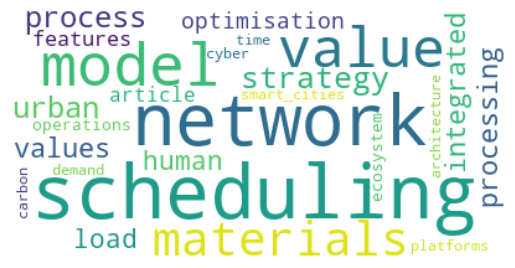

In [47]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

terms_count = 25
terms = wordvect.get_feature_names_out()

for idx,topic in enumerate(lda_model.components_):    
    print('Topic# ',idx+1)
    abs_topic = abs(topic)
    topic_terms = [[terms[i],topic[i]] for i in abs_topic.argsort()[:-terms_count-1:-1]]
    topic_terms_sorted = [[terms[i], topic[i]] for i in abs_topic.argsort()[:-terms_count - 1:-1]]
    topic_words = []
    for i in range(terms_count):
        topic_words.append(topic_terms_sorted[i][0])
    print(','.join( word for word in topic_words))
    print("")
    dict_word_frequency = {}
    
    for i in range(terms_count):
        dict_word_frequency[topic_terms_sorted[i][0]] = topic_terms_sorted[i][1]    
    wcloud = WordCloud(background_color="white",mask=None, max_words=100,\
                        max_font_size=60,min_font_size=10,prefer_horizontal=0.9,
                        contour_width=3,contour_color='black')
    wcloud.generate_from_frequencies(dict_word_frequency)       
    plt.imshow(wcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig("Topic#"+str(idx+1)+".png", format="png")

## Topic Analysis


In [48]:
#Time series
topic_labels = []

for index, row in df_topic_keywords.iterrows():
    topic_labels.append('.'.join(row[0:5].to_list()))

print(topic_labels) # labels for each topic

['buildings.applications.production.communication.approach', 'smart_cities.cloud.electricity.resource.life', 'devices.building.monitoring.networks.sensor', 'green.optimal.various.software.potential', 'new.forecasting.using.used.optimization', 'demand.machine.smart_grid.electricity.deep', 'equipment.detection.electric.deep.image', 'scheduling.network.model.value.materials']


In [49]:
data = pd.read_csv("../../../data/processed_data/data_full_processed.csv", sep=",")
my_sample = random.sample(range(1, len(data)), 3)

print(data.abstract[my_sample[0]] + "\n")
print(data.abstract[my_sample[1]] + "\n")
print(data.abstract[my_sample[2]] + "\n")

Currently, the world experiences an unprecedentedly increasing generation of application data, from sensor measurements to video streams, thanks to the extreme connectivity capability provided by 5G networks. Going beyond 5G technology, such data aim to be ingested by Artificial Intelligence (AI) functions instantiated in the network to facilitate informed decisions, essential for the operation of applications, such as automated driving and factory automation. Nonetheless, while computing platforms hosting Machine Learning (ML) models are ever powerful, their energy footprint is a key impeding factor towards realizing a wireless network as a sustainable intelligent platform. Focusing on a beyond 5G wireless network, overlaid by a Multi-access Edge Computing (MEC) infrastructure with inferencing capabilities, our paper tackles the problem of energy-aware dependable inference by considering inference effectiveness as value of a goal that needs to be accomplished by paying the minimum pri

In [50]:
vizDataFrame = pd.DataFrame({'Text_1': lda_output[my_sample[0],], 
                             'Text_2': lda_output[my_sample[1],],
                             'Text_3': lda_output[my_sample[2],]})

vizDataFrame.index = topic_labels

vizDataFrame

,Text_1,Text_2,Text_3
buildings.applications.production.communication.approach,0.008349,0.951358,0.008346
smart_cities.cloud.electricity.resource.life,0.008334,0.006945,0.008342
devices.building.monitoring.networks.sensor,0.008338,0.006946,0.008336
green.optimal.various.software.potential,0.008337,0.006950,0.008342
new.forecasting.using.used.optimization,0.008337,0.006956,0.008343
demand.machine.smart_grid.electricity.deep,0.008340,0.006949,0.008349
equipment.detection.electric.deep.image,0.008335,0.006949,0.941598
scheduling.network.model.value.materials,0.941630,0.006947,0.008343


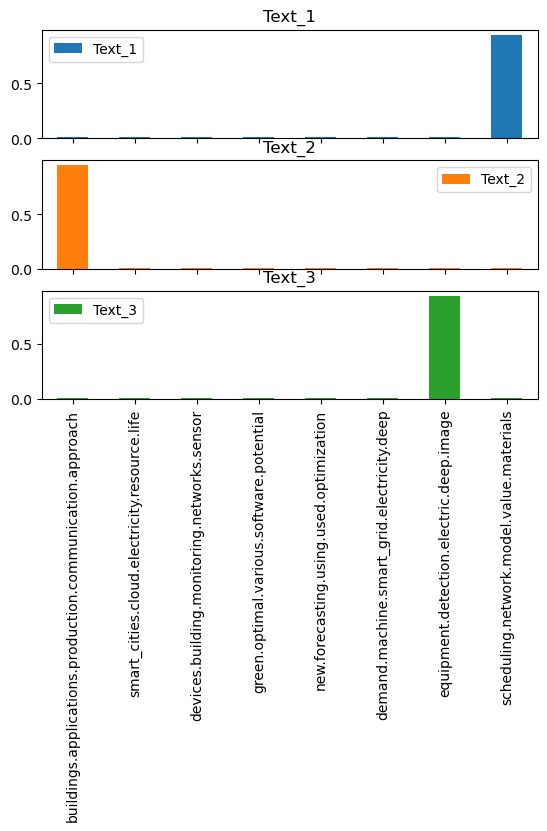

In [51]:
axes = vizDataFrame.plot.bar(rot=90, subplots=True)
axes[1].legend(loc=None) 

In [52]:
#Topic Importance
topicProportions = np.sum(lda_output, axis=0)/lda_output.shape[0]
topicProportions_df = pd.DataFrame({'Topic': topic_labels, 'Mean_Prob': topicProportions})
topicProportions_df.sort_values(by=['Mean_Prob'], inplace=True, ascending=False)
# Print the DataFrame
print(topicProportions_df)

                                               Topic  Mean_Prob
0  buildings.applications.production.communicatio...   0.157735
2        devices.building.monitoring.networks.sensor   0.148955
4            new.forecasting.using.used.optimization   0.131631
1       smart_cities.cloud.electricity.resource.life   0.128756
3           green.optimal.various.software.potential   0.117779
7           scheduling.network.model.value.materials   0.115451
5         demand.machine.smart_grid.electricity.deep   0.115045
6            equipment.detection.electric.deep.image   0.084648


In [53]:
#Rank-1 Method
num_topics = 8

countsOfPrimaryTopics = np.zeros(num_topics)

for row in lda_output:
    important_topic = (np.argsort(row)[::-1])[0]
    countsOfPrimaryTopics[important_topic] += 1

topicProportions_df_rank_1 = pd.DataFrame({'Topic': topic_labels, 'Count': countsOfPrimaryTopics})
topicProportions_df_rank_1.sort_values(by=['Count'], inplace=True, ascending=False)
# Print the DataFrame
print(topicProportions_df_rank_1)

                                               Topic  Count
0  buildings.applications.production.communicatio...   59.0
2        devices.building.monitoring.networks.sensor   57.0
4            new.forecasting.using.used.optimization   49.0
1       smart_cities.cloud.electricity.resource.life   47.0
3           green.optimal.various.software.potential   41.0
5         demand.machine.smart_grid.electricity.deep   40.0
7           scheduling.network.model.value.materials   40.0
6            equipment.detection.electric.deep.image   30.0


In [54]:
#document distribution over time
import string
from matplotlib import cm

cmap = cm.get_cmap('Spectral')
data["decade"] = data.date.apply(lambda x: x.strip()[0:3] + "0")

# Combine the 2D array with the DataFrame column using Pandas' concat function
combined_array = pd.concat([pd.DataFrame(lda_output, columns=topic_labels), data["decade"]], axis=1)
aggregated_data = combined_array.groupby('decade').mean().reset_index()
aggregated_data.set_index('decade', inplace=True)

# Create a stacked bar chart
aggregated_data.plot.area(stacked=True,colormap=cmap, legend='reverse').legend(
    bbox_to_anchor=(1.0, 1.0),
    fontsize='small',

)

# Optional: Customize the plot
import matplotlib.pyplot as plt

plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Stacked Bar Chart')

plt.show()

/var/folders/tr/11z_m_bn5pxg8m0m7762nzl00000gn/T/ipykernel_16513/38329428.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Spectral')


AttributeError: 'DataFrame' object has no attribute 'date'

In [ ]:
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
# pip install tmtoolkit
# lda_model - LatentDirichletAllocation()
# vect - CountVectorizer()
# texts - the list of tokenized words
metric_coherence_gensim(measure='c_v', 
                        top_n=25, 
                        topic_word_distrib=lda_model.components_, 
                        dtm=dtm, 
                        vocab=np.array([x for x in wordvect.get_feature_names_out()]), 
                        texts=data.text.values)

AttributeError: 'DataFrame' object has no attribute 'text'